# Sig Phosphoproteomic Comparison 


## Step 1: Library Imports

Run this cell to import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re

import cptac
import cptac.utils as u

In [2]:
def add_significance_col(results_df, num_comparisons):
    "bonferroni multiple hypothesis"""
    alpha = .05
    bonferroni_cutoff = alpha / num_comparisons
    
    pval = results_df['P_Value']
    if float(pval[0]) <= bonferroni_cutoff:
        results_df['Significant'] = True
    else: 
        results_df['Significant'] = False
    return results_df

def wrap_ttest_return_all(df, label_column, comparison_columns, total_tests, alpha=.05):
    try:
        #Verify precondition that label column exists and has exactly 2 unique values
        label_values = df[label_column].unique()
        if len(label_values) != 2:
            print("Incorrectly Formatted Dataframe! Label column must have exactly 2 unique values.")
            return None
        
        #Partition dataframe into two sets, one for each of the two unique values from the label column
        partition1 = df.loc[df[label_column] == label_values[0]]
        partition2 = df.loc[df[label_column] == label_values[1]]
        
        #Determine the number of real valued columns on which we will do t-tests
        #sites = len(comparison_columns.columns)
        number_of_comparisons = total_tests # ? phospho sites or num freq mut genes doing cis comp
        
        #Use a bonferroni correction to adjust for multiple testing by altering the p-value needed for acceptance
        bonferroni_cutoff = alpha/number_of_comparisons
        
        #Store all comparisons with their p-values in a dictionary
        all_comparisons = {}
        
        #Loop through each comparison column, perform the t-test, and determine whether it meets the significance cutoff'''
        for column in comparison_columns:
            stat, pval = scipy.stats.ttest_ind(partition1[column].dropna(axis=0), partition2[column].dropna(axis=0))
            all_comparisons[column] = pval
    
        #Sort dictionary to list smallest p-values first
        sorted_comparisons = sorted(all_comparisons.items(), key=lambda kv: kv[1])
        #Format as a dataframe and return to caller
        all_comparisons_df = pd.DataFrame.from_dict(sorted_comparisons)
        all_comparisons_df.columns = ['Comparison', 'P_Value']
        
                                               
        all_comparisons_sig_col = add_significance_col(all_comparisons_df, number_of_comparisons)
        return all_comparisons_sig_col
                                
    except:
        print("Incorrectly Formatted Dataframe!")
        return None


In [3]:
# note: pass reduced omics # CHECK would include non coding, but none in fm genes

def format_mutated_wt_comparison(reduced_omics_df):
    # Step 2 - Create binary column 
    reduced_omics_df['binary_mutations'] = np.where(
                reduced_omics_df[gene+'_Mutation_Status'] == 'Wildtype_Tumor', 'Wildtype', 'Mutated')

    # Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
    tumors = reduced_omics_df[reduced_omics_df.Sample_Status == 'Tumor'] #drop Normal samples
    columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
    mut_status = tumors.drop(columns_to_drop, axis = 1)

    return mut_status

In [4]:
def get_missense_truncation_comparison(cancer_object, reduced_omics_df):
    #get omics data and tumors
    tumors = reduced_omics_df.loc[reduced_omics_df['Sample_Status'] == 'Tumor'] #drop Normal samples


    somatic_mutations = cancer_object.get_somatic_mutation().reset_index()

    if cancer_object.get_cancer_type() == 'colon':
        missence_truncation_groups = {'frameshift substitution': 'Truncation', 
            'frameshift deletion': 'Truncation', 'frameshift insertion': 'Truncation', 
            'stopgain': 'Truncation', 'stoploss': 'Truncation', 'nonsynonymous SNV': 'Missense',
            'nonframeshift insertion': 'Missense','nonframeshift deletion': 'Missense', 
            'nonframeshift substitution': 'Missense'}
    else: 
        missence_truncation_groups = {'In_Frame_Del': 'Missense', 'In_Frame_Ins': 'Missense',
            'Missense_Mutation': 'Missense', 'Frame_Shift_Del': 'Truncation','Nonsense_Mutation': 'Truncation', 
            'Splice_Site': 'Truncation', 'Frame_Shift_Ins': 'Truncation','Nonstop_Mutation':'Truncation'}

    mutations_replaced_M_T = somatic_mutations.replace(missence_truncation_groups)
    mutations_replaced_M_T = mutations_replaced_M_T.loc[mutations_replaced_M_T['Gene'] == gene]

    # group mutation categories
    miss = mutations_replaced_M_T.loc[mutations_replaced_M_T['Mutation'] == 'Missense']
    trunc = mutations_replaced_M_T.loc[mutations_replaced_M_T['Mutation'] == 'Truncation']

    #get lists of unique samples for missence and trucation categories
    miss_unique_samples = list(miss['Sample_ID'].unique())
    trunc_unique_samples = list(trunc['Sample_ID'].unique())
    
    #check if there is only one type of mutation for the specific gene
    if miss_unique_samples == []:
        print('Only truncation type mutations found for', gene+'.', 
             'Not possible to compare missense with wildtype.')
        truncation_omics = tumors.loc[tumors.index.isin(trunc_unique_samples)]
        truncation_omics = truncation_omics.assign(binary_mutations = 'Truncation')
        columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
        binary_mut_omics = truncation_omics.drop(columns_to_drop, axis = 1)
        return binary_mut_omics
    elif trunc_unique_samples == []:
        print('Only missence type mutations found for', gene+'.', 
             'Not possible to compare truncation with wildtype.')
        missence_omics = tumors.loc[tumors.index.isin(miss_unique_samples)]
        missence_omics = missence_omics.assign(binary_mutations = 'Missense')
        columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
        binary_mut_omics = missence_omics.drop(columns_to_drop, axis = 1)
        return binary_mut_omics

    ### Step 2 - Create the binary column needed to do the comparison
    # Get mutation catagories with omics data
    missence_omics = tumors.loc[tumors.index.isin(miss_unique_samples)]
    missence_omics = missence_omics.assign(binary_mutations = 'Missense')
    truncation_omics = tumors.loc[tumors.index.isin(trunc_unique_samples)]
    truncation_omics = truncation_omics.assign(binary_mutations = 'Truncation')
    binary_mut_omics = missence_omics.append(truncation_omics)

    # Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
    columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
    binary_mut_omics = binary_mut_omics.drop(columns_to_drop, axis = 1)

    return binary_mut_omics


In [5]:
def format_pval_annotation(pval_symbol, x1, x2, line_start = .05, line_height=.05):
    # for manual adjustment to pval annotations
    
    y, h = line_start, line_height
    plt.plot([x1, x1, x2, x2], #draw horizontal line
             [y, y+h, y+h, y], #vertical line
             lw=1.5, color= '.3')
    plt.text((x1+x2)*.5, # half between x coord
             y+h, pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")

# used in pval_annotation
def get_pval_symbol(pval_df):
    if pval_df.iloc[0:,2].bool() == True:
        pval_symbol = '*'
    else:
        pval_symbol = 'ns'
    return pval_symbol

def pval_annotation(pval_df, plotted_df):
    # pval symbol
    num_pvals = len(pval_df)
    omics_col = plotted_df.columns[0]
    

    # annotation for Mutated and Wiltype
    if num_pvals == 1:
        mut_pval = pval_df.loc[pval_df.index == "Mutated/Wildtype"]
        mut_pval_symbol = get_pval_symbol(pval_df)
        
        x1, x2 = 0, 1   # columns (first column: 0, see plt.xticks())
        y, h = plotted_df[omics_col].max() + .05, .05     
        plt.plot([x1, x1, x2, x2], #draw horizontal line
                 [y, y+h, y+h, y], #vertical line
                 lw=1.5, color= '.3')
        plt.text((x1+x2)*.5, # half between x coord
                 y+h, mut_pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")
    
    # annotation for Missense, Truncation and Wildtype
    elif num_pvals == 2:
        # Missense
        miss_pval = pval_df.loc[pval_df.index == "Missense/Wildtype"]
        miss_pval_symbol = get_pval_symbol(miss_pval)
    
        x1, x2 = 0, 1   # columns (first column: 0, see plt.xticks())
        y, h = plotted_df[omics_col].max() + .05, .05     
        plt.plot([x1, x1, x2, x2], #draw horizontal line
                 [y, y+h, y+h, y], #vertical line
                 lw=1.5, color= '.3')
        plt.text((x1+x2)*.5, # half between x coord
                 y+h, miss_pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")
        
        # Truncation 
        trunc_pval = pval_df.loc[pval_df.index == "Truncation/Wildtype"]
        trunc_pval_symbol = get_pval_symbol(trunc_pval)
        
        x3, x4 = 0, 2   # columns (first column: 0, see plt.xticks())
        y2, h2 = plotted_df[omics_col].max() + .15, .05     
        plt.plot([x3, x3, x4, x4], #draw horizontal line
                 [y2, y2+h2, y2+h2, y2], #vertical line
                 lw=1.5, color= '.3')
        plt.text((x3+x4)*.5, # half between x coord
                 y2+h2, trunc_pval_symbol, horizontalalignment='center', verticalalignment='bottom', color = "black")


## Step 2: Find the mutation frequency of the gene of interest

In [6]:
#cptac.download(dataset='ccrcc', version='0.0')
brain = cptac.Gbm()
desired_cutoff = 0.05
gene = 'RB1'

## Step 3: cis comparisons for omics 

Determine if the DNA mutation has an effect on the omics measurement. In order to do this, we have a few steps in code. These steps are found in the format_cis_comparison_data function.
1. get a table with both the omics and mutation data for tumors
2. get a binary column from the mutation data to separate our samples
3. format data frame to be used in the T-test
4. send data to the T-test.

The format_cis_comparison_data does the first 3 steps (for dataframes with multi-indexes).

# Phosphopoteomics RB1

Proteomics: Mutated and Wildtype rb1

In [40]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest  
phospho_and_mut = brain.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'phosphoproteomics', omics_genes = "RB1") # single col level
flatten_phospho_and_mut = brain.reduce_multiindex(phospho_and_mut, levels_to_drop=["Database_ID"], flatten=True)#reduce multi columns

# Step 2 - Create the binary column needed to do the comparison
flatten_phospho_and_mut['binary_mutations'] = flatten_phospho_and_mut[gene+'_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

# Step 3 - Format
phospho_tumors = flatten_phospho_and_mut.query('Sample_Status != "Normal"') # drop Normal samples (warning with .loc)
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_phospho = phospho_tumors.drop(columns_to_drop, axis = 1)
only_phospho = binary_phospho.drop('binary_mutations', axis = 1)

In [41]:
# Use al.wrap_ttest for many columns of phospho data (takes phospho sites into account with bonferroni cutoff)
phos_col_list = list(only_phospho.columns)

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutation status")
phos_pval_results = u.wrap_ttest(binary_phospho, 'binary_mutations', phos_col_list)
phos_pval_results

Doing t-test comparison for mutation status
5 significant comparisons!


,Comparison,P_Value
0,RB1_phosphoproteomics_S788_TNILQYASTRPPTLSPIPH...,0.000015
1,RB1_phosphoproteomics_T356_TLQTDSIDSFETQRT*PRK,0.000104
2,RB1_phosphoproteomics_S249_TAVIPINGS*PR,0.000291
3,RB1_phosphoproteomics_S807S811_IPGGNIYIS*PLKS*PYK,0.000583
4,RB1_phosphoproteomics_S612_DREGPTDHLESACPLNLPL...,0.000986


In [42]:
# Create data frame with all significant phospho sites in order to graph
phospho_list = list(phos_pval_results['Comparison']) # comment when no sig phospho sites

phospho_df_RB1 = pd.melt(binary_phospho, id_vars = 'binary_mutations', 
            value_vars = phospho_list, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phospho_df_RB1.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
phospho_df_RB1.replace(to_replace = '_[A-Z]*\*[A-Z]*\*?[A-Z]*', value = '', 
                        inplace = True, regex = True)

phospho_df_RB1

,binary_mutations,specific_phospho,phosphoproteomics
0,Mutated,RB1_S788,-0.678
1,Mutated,RB1_S788,-0.152
2,Wildtype,RB1_S788,-0.239
3,Mutated,RB1_S788,-0.625
4,Wildtype,RB1_S788,-0.178
...,...,...,...
495,Wildtype,RB1_S612,-0.426
496,Wildtype,RB1_S612,0.791
497,Wildtype,RB1_S612,-0.239
498,Wildtype,RB1_S612,-0.232


Proteomics: Missense and Truncation compared to wildtype

In [43]:
# select all wildtype from earlier -add to mut_type binary column
phos_wildtype = binary_phospho.loc[binary_phospho['binary_mutations'] == 'Wildtype'] 

phos_mut_type = get_missense_truncation_comparison(brain, flatten_phospho_and_mut)
phos_mut_and_wildtype = phos_mut_type.append(phos_wildtype, sort=True) 

phos_col_list = list(only_phospho.columns)

# compare truncation and wildtype 
trunc_wt = phos_mut_and_wildtype.loc[phos_mut_and_wildtype['binary_mutations'] != 'Missense']
print("\n\nDoing t-test comparison for truncation and wildtype\n")
phos_results_trunc = u.wrap_ttest(trunc_wt, 'binary_mutations', phos_col_list)
phos_results_trunc

Only truncation type mutations found for RB1. Not possible to compare missense with wildtype.


Doing t-test comparison for truncation and wildtype

5 significant comparisons!


,Comparison,P_Value
0,RB1_phosphoproteomics_S788_TNILQYASTRPPTLSPIPH...,0.000015
1,RB1_phosphoproteomics_T356_TLQTDSIDSFETQRT*PRK,0.000104
2,RB1_phosphoproteomics_S249_TAVIPINGS*PR,0.000291
3,RB1_phosphoproteomics_S807S811_IPGGNIYIS*PLKS*PYK,0.000583
4,RB1_phosphoproteomics_S612_DREGPTDHLESACPLNLPL...,0.000986


In [61]:
# Create data frame with all significant phospho sites in order to graph
phospho_list_trunc = list(phos_results_trunc['Comparison']) # comment when no sig phospho sites

phospho_df_RB1_t = pd.melt(phos_mut_and_wildtype, id_vars = 'binary_mutations', 
            value_vars = phospho_list_trunc, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phospho_df_RB1_t.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
phospho_df_RB1_t.replace(to_replace = '_[A-Z]*\*[A-Z]*\*?[A-Z]*', value = '', 
                        inplace = True, regex = True)

phospho_df_RB1_t

,binary_mutations,specific_phospho,phosphoproteomics
0,Truncation,RB1_S788,-0.678
1,Truncation,RB1_S788,-0.152
2,Truncation,RB1_S788,-0.625
3,Truncation,RB1_S788,-0.163
4,Truncation,RB1_S788,-1.600
...,...,...,...
495,Wildtype,RB1_S612,-0.426
496,Wildtype,RB1_S612,0.791
497,Wildtype,RB1_S612,-0.239
498,Wildtype,RB1_S612,-0.232


# MCM2 

In [12]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest  
phospho_and_mut_MCM2 = brain.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'phosphoproteomics', omics_genes = ["MCM2"]) # single col level
flatten_phospho_and_mut_MCM2 = brain.reduce_multiindex(phospho_and_mut_MCM2, levels_to_drop=3, flatten=True)#reduce multi columns

# Step 2 - Create the binary column needed to do the comparison
flatten_phospho_and_mut_MCM2['binary_mutations'] = flatten_phospho_and_mut_MCM2[gene+'_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

# Step 3 - Format
phospho_tumors_MCM2 = flatten_phospho_and_mut_MCM2.query('Sample_Status != "Normal"') # drop Normal samples (warning with .loc)
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_phospho_MCM2 = phospho_tumors_MCM2.drop(columns_to_drop, axis = 1)
only_phospho_MCM2 = binary_phospho_MCM2.drop('binary_mutations', axis = 1)

In [13]:
# Use al.wrap_ttest for many columns of phospho data (takes phospho sites into account with bonferroni cutoff)
phos_col_list_MCM2 = list(only_phospho_MCM2.columns)

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutation status")
phos_pval_results_MCM2 = u.wrap_ttest(binary_phospho_MCM2, 'binary_mutations', phos_col_list_MCM2)
phos_pval_results_MCM2

Doing t-test comparison for mutation status
4 significant comparisons!


,Comparison,P_Value
0,MCM2_phosphoproteomics_S108_AIPELDAYEAEGLALDDE...,0.000065
1,MCM2_phosphoproteomics_S139_GLLYDS*DEEDEERPARK,0.002284
2,MCM2_phosphoproteomics_S139_GLLYDS*DEEDEERPAR,0.002635
3,MCM2_phosphoproteomics_S41_RTDALTSS*PGR,0.002764


In [14]:
# Create data frame with all significant phospho sites in order to graph
phospho_list_MCM2 = list(phos_pval_results_MCM2['Comparison']) # comment when no sig phospho sites

phospho_df_MCM2 = pd.melt(binary_phospho_MCM2, id_vars = 'binary_mutations', 
            value_vars = phospho_list_MCM2, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phospho_df_MCM2.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
phospho_df_MCM2.replace(to_replace = '_\*?[A-Z]*\*[A-Z]*\*?[A-Z]*', value = '', # 3 stars
                        inplace = True, regex = True)

phospho_df_MCM2

,binary_mutations,specific_phospho,phosphoproteomics
0,Mutated,MCM2_S108,-0.0771
1,Mutated,MCM2_S108,0.4620
2,Wildtype,MCM2_S108,-1.2800
3,Mutated,MCM2_S108,NaN
4,Wildtype,MCM2_S108,-1.6000
...,...,...,...
395,Wildtype,MCM2_S41,NaN
396,Wildtype,MCM2_S41,0.7830
397,Wildtype,MCM2_S41,NaN
398,Wildtype,MCM2_S41,NaN


In [15]:
# select all wildtype from earlier -add to mut_type binary column
phos_wildtype_MCM2 = binary_phospho_MCM2.loc[binary_phospho_MCM2['binary_mutations'] == 'Wildtype'] 

phos_mut_type_MCM2 = get_missense_truncation_comparison(brain, flatten_phospho_and_mut_MCM2)
phos_mut_and_wildtype_MCM2 = phos_mut_type_MCM2.append(phos_wildtype_MCM2, sort=True) 

phos_col_list_MCM2 = list(only_phospho_MCM2.columns)

# compare truncation and wildtype 
trunc_wt_MCM2 = phos_mut_and_wildtype_MCM2.loc[phos_mut_and_wildtype_MCM2['binary_mutations'] != 'Missense']
print("\n\nDoing t-test comparison for truncation and wildtype\n")
phos_results_trunc_MCM2 = u.wrap_ttest(trunc_wt_MCM2, 'binary_mutations', phos_col_list_MCM2)
phos_results_trunc_MCM2

Only truncation type mutations found for RB1. Not possible to compare missense with wildtype.


Doing t-test comparison for truncation and wildtype

4 significant comparisons!


,Comparison,P_Value
0,MCM2_phosphoproteomics_S108_AIPELDAYEAEGLALDDE...,0.000065
1,MCM2_phosphoproteomics_S139_GLLYDS*DEEDEERPARK,0.002284
2,MCM2_phosphoproteomics_S139_GLLYDS*DEEDEERPAR,0.002635
3,MCM2_phosphoproteomics_S41_RTDALTSS*PGR,0.002764


In [57]:
# Create data frame with all significant phospho sites in order to graph
phospho_list_MCM2_trunc = list(phos_results_trunc_MCM2['Comparison']) # comment when no sig phospho sites

phospho_df_MCM2_t = pd.melt(phos_mut_and_wildtype_MCM2, id_vars = 'binary_mutations', 
            value_vars = phospho_list_MCM2_trunc, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phospho_df_MCM2_t.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
phospho_df_MCM2_t.replace(to_replace = '_[A-Z]*\*[A-Z]*\*?[A-Z]*', value = '', 
                        inplace = True, regex = True)

phospho_df_MCM2_t

,binary_mutations,specific_phospho,phosphoproteomics
0,Truncation,MCM2_S108,-0.0771
1,Truncation,MCM2_S108,0.4620
2,Truncation,MCM2_S108,NaN
3,Truncation,MCM2_S108,2.4800
4,Truncation,MCM2_S108,NaN
...,...,...,...
395,Wildtype,MCM2_S41,NaN
396,Wildtype,MCM2_S41,0.7830
397,Wildtype,MCM2_S41,NaN
398,Wildtype,MCM2_S41,NaN


# MCM3

In [46]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest  
phospho_and_mut_MCM3 = brain.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'phosphoproteomics', omics_genes = ["MCM3"]) # single col level
flatten_phospho_and_mut_MCM3 = brain.reduce_multiindex(phospho_and_mut_MCM3, levels_to_drop=3, flatten=True)#reduce multi columns

# Step 2 - Create the binary column needed to do the comparison
flatten_phospho_and_mut_MCM3['binary_mutations'] = flatten_phospho_and_mut_MCM3[gene+'_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

# Step 3 - Format
phospho_tumors_MCM3 = flatten_phospho_and_mut_MCM3.query('Sample_Status != "Normal"') # drop Normal samples (warning with .loc)
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_phospho_MCM3 = phospho_tumors_MCM3.drop(columns_to_drop, axis = 1)
only_phospho_MCM3 = binary_phospho_MCM3.drop('binary_mutations', axis = 1)

In [47]:
# Use al.wrap_ttest for many columns of phospho data (takes phospho sites into account with bonferroni cutoff)
phos_col_list_MCM3 = list(only_phospho_MCM3.columns)

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutation status")
phos_pval_results_MCM3 = u.wrap_ttest(binary_phospho_MCM3, 'binary_mutations', phos_col_list_MCM3)
phos_pval_results_MCM3

Doing t-test comparison for mutation status
5 significant comparisons!


,Comparison,P_Value
0,MCM3_phosphoproteomics_S205_RYS*DLTTLVAFPSSSVYPTK,6.515536e-07
1,MCM3_phosphoproteomics_S717T719_RSEDES*ET*EDEEEK,1.877836e-04
2,MCM3_phosphoproteomics_T758T767_DGDSYDPYDFSDT*...,2.127755e-04
3,MCM3_phosphoproteomics_S756T758_DGDSYDPYDFS*DT...,4.058353e-04
4,MCM3_phosphoproteomics_S713S717T719_KRS*EDES*E...,5.854894e-04


In [48]:
# Create data frame with all significant phospho sites in order to graph
phospho_list_MCM3 = list(phos_pval_results_MCM3['Comparison']) # comment when no sig phospho sites

phospho_df_MCM3 = pd.melt(binary_phospho_MCM3, id_vars = 'binary_mutations', 
            value_vars = phospho_list_MCM3, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phospho_df_MCM3.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
phospho_df_MCM3.replace(to_replace = '_\*?[A-Z]*\*[A-Z]*\*?[A-Z]*\*?[A-Z]*', value = '', # 3 stars
                        inplace = True, regex = True)

phospho_df_MCM3

,binary_mutations,specific_phospho,phosphoproteomics
0,Mutated,MCM3_S205,1.040
1,Mutated,MCM3_S205,1.190
2,Wildtype,MCM3_S205,0.208
3,Mutated,MCM3_S205,-0.360
4,Wildtype,MCM3_S205,-0.548
...,...,...,...
495,Wildtype,MCM3_S713S717T719,0.568
496,Wildtype,MCM3_S713S717T719,1.890
497,Wildtype,MCM3_S713S717T719,-0.889
498,Wildtype,MCM3_S713S717T719,-0.171


In [49]:
# select all wildtype from earlier -add to mut_type binary column
phos_wildtype_MCM3 = binary_phospho_MCM3.loc[binary_phospho_MCM3['binary_mutations'] == 'Wildtype'] 

phos_mut_type_MCM3 = get_missense_truncation_comparison(brain, flatten_phospho_and_mut_MCM3)
phos_mut_and_wildtype_MCM3 = phos_mut_type_MCM3.append(phos_wildtype_MCM3, sort=True) 

phos_col_list_MCM3 = list(only_phospho_MCM3.columns)

# compare truncation and wildtype 
trunc_wt_MCM3 = phos_mut_and_wildtype_MCM3.loc[phos_mut_and_wildtype_MCM3['binary_mutations'] != 'Missense']
print("\n\nDoing t-test comparison for truncation and wildtype\n")
phos_results_trunc_MCM3 = u.wrap_ttest(trunc_wt_MCM3, 'binary_mutations', phos_col_list_MCM3)
phos_results_trunc_MCM3

Only truncation type mutations found for RB1. Not possible to compare missense with wildtype.


Doing t-test comparison for truncation and wildtype

5 significant comparisons!


,Comparison,P_Value
0,MCM3_phosphoproteomics_S205_RYS*DLTTLVAFPSSSVYPTK,6.515536e-07
1,MCM3_phosphoproteomics_S717T719_RSEDES*ET*EDEEEK,1.877836e-04
2,MCM3_phosphoproteomics_T758T767_DGDSYDPYDFSDT*...,2.127755e-04
3,MCM3_phosphoproteomics_S756T758_DGDSYDPYDFS*DT...,4.058353e-04
4,MCM3_phosphoproteomics_S713S717T719_KRS*EDES*E...,5.854894e-04


In [60]:
# Create data frame with all significant phospho sites in order to graph
phospho_list_MCM3_trunc = list(phos_results_trunc_MCM3['Comparison']) # comment when no sig phospho sites

phospho_df_MCM3_t = pd.melt(phos_mut_and_wildtype_MCM3, id_vars = 'binary_mutations', 
            value_vars = phospho_list_MCM3_trunc, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phospho_df_MCM3_t.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
phospho_df_MCM3_t.replace(to_replace = '_[A-Z]*\*[A-Z]*\*?[A-Z]*\*?[A-Z]*', value = '', 
                        inplace = True, regex = True)

phospho_df_MCM3_t

,binary_mutations,specific_phospho,phosphoproteomics
0,Truncation,MCM3_S205,1.040
1,Truncation,MCM3_S205,1.190
2,Truncation,MCM3_S205,-0.360
3,Truncation,MCM3_S205,2.360
4,Truncation,MCM3_S205,0.984
...,...,...,...
495,Wildtype,MCM3_S713S717T719,0.568
496,Wildtype,MCM3_S713S717T719,1.890
497,Wildtype,MCM3_S713S717T719,-0.889
498,Wildtype,MCM3_S713S717T719,-0.171


# MCM6

In [50]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest  
phospho_and_mut_MCM6 = brain.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'phosphoproteomics', omics_genes = ["MCM6"]) # single col level
flatten_phospho_and_mut_MCM6 = brain.reduce_multiindex(phospho_and_mut_MCM6, levels_to_drop=3, flatten=True)#reduce multi columns

# Step 2 - Create the binary column needed to do the comparison
flatten_phospho_and_mut_MCM6['binary_mutations'] = flatten_phospho_and_mut_MCM6[gene+'_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

# Step 3 - Format
phospho_tumors_MCM6 = flatten_phospho_and_mut_MCM6.query('Sample_Status != "Normal"') # drop Normal samples (warning with .loc)
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_phospho_MCM6 = phospho_tumors_MCM6.drop(columns_to_drop, axis = 1)
only_phospho_MCM6 = binary_phospho_MCM6.drop('binary_mutations', axis = 1)

In [51]:
# Use al.wrap_ttest for many columns of phospho data (takes phospho sites into account with bonferroni cutoff)
phos_col_list_MCM6 = list(only_phospho_MCM6.columns)

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutation status")
phos_pval_results_MCM6 = u.wrap_ttest(binary_phospho_MCM6, 'binary_mutations', phos_col_list_MCM6)
#phos_pval_results = phos_pval_results.rename(index = {0: "Mutated/Wildtype"})
phos_pval_results_MCM6

Doing t-test comparison for mutation status
2 significant comparisons!


,Comparison,P_Value
0,MCM6_phosphoproteomics_S762_EIESEIDS*EEELINKK,6.407922e-07
1,MCM6_phosphoproteomics_S762_EIESEIDS*EEELINK,1.560358e-05


In [52]:
# Create data frame with all significant phospho sites in order to graph
phospho_list_MCM6 = list(phos_pval_results_MCM6['Comparison']) # comment when no sig phospho sites

phospho_df_MCM6 = pd.melt(binary_phospho_MCM6, id_vars = 'binary_mutations', 
            value_vars = phospho_list_MCM6, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phospho_df_MCM6.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
phospho_df_MCM6.replace(to_replace = '_[A-Z]*\*[A-Z]*', value = '', 
                        inplace = True, regex = True)

phospho_df_MCM6

,binary_mutations,specific_phospho,phosphoproteomics
0,Mutated,MCM6_S762,1.240
1,Mutated,MCM6_S762,1.100
2,Wildtype,MCM6_S762,-1.730
3,Mutated,MCM6_S762,1.150
4,Wildtype,MCM6_S762,-1.800
...,...,...,...
195,Wildtype,MCM6_S762,NaN
196,Wildtype,MCM6_S762,-0.356
197,Wildtype,MCM6_S762,-1.090
198,Wildtype,MCM6_S762,NaN


In [53]:
# select all wildtype from earlier -add to mut_type binary column
phos_wildtype_MCM6 = binary_phospho_MCM6.loc[binary_phospho_MCM6['binary_mutations'] == 'Wildtype'] 

phos_mut_type_MCM6 = get_missense_truncation_comparison(brain, flatten_phospho_and_mut_MCM6)
phos_mut_and_wildtype_MCM6 = phos_mut_type_MCM6.append(phos_wildtype_MCM6, sort=True) 

phos_col_list_MCM6 = list(only_phospho_MCM6.columns)

# compare truncation and wildtype 
trunc_wt_MCM6 = phos_mut_and_wildtype_MCM6.loc[phos_mut_and_wildtype_MCM6['binary_mutations'] != 'Missense']
print("\n\nDoing t-test comparison for truncation and wildtype\n")
phos_results_trunc_MCM6 = u.wrap_ttest(trunc_wt_MCM6, 'binary_mutations', phos_col_list_MCM6)
phos_results_trunc_MCM6

Only truncation type mutations found for RB1. Not possible to compare missense with wildtype.


Doing t-test comparison for truncation and wildtype

2 significant comparisons!


,Comparison,P_Value
0,MCM6_phosphoproteomics_S762_EIESEIDS*EEELINKK,6.407922e-07
1,MCM6_phosphoproteomics_S762_EIESEIDS*EEELINK,1.560358e-05


In [55]:
# Create data frame with all significant phospho sites in order to graph
phospho_list_MCM6_trunc = list(phos_results_trunc_MCM6['Comparison']) # comment when no sig phospho sites

phospho_df_MCM6_t = pd.melt(phos_mut_and_wildtype_MCM6, id_vars = 'binary_mutations', 
            value_vars = phospho_list_MCM6_trunc, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phospho_df_MCM6_t.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
phospho_df_MCM6_t.replace(to_replace = '_[A-Z]*\*[A-Z]*\*?[A-Z]*', value = '', 
                        inplace = True, regex = True)

phospho_df_MCM6_t

,binary_mutations,specific_phospho,phosphoproteomics
0,Truncation,MCM6_S762,1.240
1,Truncation,MCM6_S762,1.100
2,Truncation,MCM6_S762,1.150
3,Truncation,MCM6_S762,NaN
4,Truncation,MCM6_S762,NaN
...,...,...,...
195,Wildtype,MCM6_S762,NaN
196,Wildtype,MCM6_S762,-0.356
197,Wildtype,MCM6_S762,-1.090
198,Wildtype,MCM6_S762,NaN


# CCNE1

In [24]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest  
phospho_and_mut_CCNE1 = brain.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'phosphoproteomics', omics_genes = ["CCNE1"]) # single col level
flatten_phospho_and_mut_CCNE1 = brain.reduce_multiindex(phospho_and_mut_CCNE1, levels_to_drop=3, flatten=True)#reduce multi columns

# Step 2 - Create the binary column needed to do the comparison
flatten_phospho_and_mut_CCNE1['binary_mutations'] = flatten_phospho_and_mut_CCNE1[gene+'_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

# Step 3 - Format
phospho_tumors_CCNE1 = flatten_phospho_and_mut_CCNE1.query('Sample_Status != "Normal"') # drop Normal samples (warning with .loc)
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_phospho_CCNE1 = phospho_tumors_CCNE1.drop(columns_to_drop, axis = 1)
only_phospho_CCNE1 = binary_phospho_CCNE1.drop('binary_mutations', axis = 1)

In [25]:
# Use al.wrap_ttest for many columns of phospho data (takes phospho sites into account with bonferroni cutoff)
phos_col_list_CCNE1 = list(only_phospho_CCNE1.columns)

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutation status")
phos_pval_results_CCNE1 = u.wrap_ttest(binary_phospho_CCNE1, 'binary_mutations', phos_col_list_CCNE1)
phos_pval_results_CCNE1

Doing t-test comparison for mutation status
1 significant comparisons!


,Comparison,P_Value
0,CCNE1_phosphoproteomics_S387_AMLSEQNRAS*PLPSGL...,8.092599e-07


In [26]:
# Create data frame with all significant phospho sites in order to graph
phospho_list_CCNE1 = list(phos_pval_results_CCNE1['Comparison']) # comment when no sig phospho sites

phospho_df_CCNE1 = pd.melt(binary_phospho_CCNE1, id_vars = 'binary_mutations', 
            value_vars = phospho_list_CCNE1, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phospho_df_CCNE1.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
phospho_df_CCNE1.replace(to_replace = '_[A-Z]*\*[A-Z]*', value = '', 
                        inplace = True, regex = True)

phospho_df_CCNE1

,binary_mutations,specific_phospho,phosphoproteomics
0,Mutated,CCNE1_S387,-0.42500
1,Mutated,CCNE1_S387,NaN
2,Wildtype,CCNE1_S387,0.40600
3,Mutated,CCNE1_S387,NaN
4,Wildtype,CCNE1_S387,-0.56600
...,...,...,...
95,Wildtype,CCNE1_S387,-0.00347
96,Wildtype,CCNE1_S387,NaN
97,Wildtype,CCNE1_S387,-0.50300
98,Wildtype,CCNE1_S387,0.26900


In [27]:
# select all wildtype from earlier -add to mut_type binary column
phos_wildtype_CCNE1 = binary_phospho_CCNE1.loc[binary_phospho_CCNE1['binary_mutations'] == 'Wildtype'] 

phos_mut_type_CCNE1 = get_missense_truncation_comparison(brain, flatten_phospho_and_mut_CCNE1)
phos_mut_and_wildtype_CCNE1 = phos_mut_type_CCNE1.append(phos_wildtype_CCNE1, sort=True) 

phos_col_list_CCNE1 = list(only_phospho_CCNE1.columns)

# compare truncation and wildtype 
trunc_wt_CCNE1 = phos_mut_and_wildtype_CCNE1.loc[phos_mut_and_wildtype_CCNE1['binary_mutations'] != 'Missense']
print("\n\nDoing t-test comparison for truncation and wildtype\n")
phos_results_trunc_CCNE1 = u.wrap_ttest(trunc_wt_CCNE1, 'binary_mutations', phos_col_list_CCNE1)
phos_results_trunc_CCNE1

Only truncation type mutations found for RB1. Not possible to compare missense with wildtype.


Doing t-test comparison for truncation and wildtype

1 significant comparisons!


,Comparison,P_Value
0,CCNE1_phosphoproteomics_S387_AMLSEQNRAS*PLPSGL...,8.092599e-07


In [59]:
# Create data frame with all significant phospho sites in order to graph
phospho_list_CCNE1_trunc = list(phos_results_trunc_CCNE1['Comparison']) # comment when no sig phospho sites

phospho_df_CCNE1_t = pd.melt(phos_mut_and_wildtype_CCNE1, id_vars = 'binary_mutations', 
            value_vars = phospho_list_CCNE1_trunc, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phospho_df_CCNE1_t.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
phospho_df_CCNE1_t.replace(to_replace = '_[A-Z]*\*[A-Z]*\*?[A-Z]*', value = '', 
                        inplace = True, regex = True)

phospho_df_CCNE1_t

,binary_mutations,specific_phospho,phosphoproteomics
0,Truncation,CCNE1_S387,-0.42500
1,Truncation,CCNE1_S387,NaN
2,Truncation,CCNE1_S387,NaN
3,Truncation,CCNE1_S387,1.68000
4,Truncation,CCNE1_S387,0.27600
...,...,...,...
95,Wildtype,CCNE1_S387,-0.00347
96,Wildtype,CCNE1_S387,NaN
97,Wildtype,CCNE1_S387,-0.50300
98,Wildtype,CCNE1_S387,0.26900


# PRKDC

In [62]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest  
phospho_and_mut_PRKDC = brain.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'phosphoproteomics', omics_genes = ["PRKDC"]) # single col level
flatten_phospho_and_mut_PRKDC = brain.reduce_multiindex(phospho_and_mut_PRKDC, levels_to_drop=3, flatten=True)#reduce multi columns

# Step 2 - Create the binary column needed to do the comparison
flatten_phospho_and_mut_PRKDC['binary_mutations'] = flatten_phospho_and_mut_PRKDC[gene+'_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

# Step 3 - Format
phospho_tumors_PRKDC = flatten_phospho_and_mut_PRKDC.query('Sample_Status != "Normal"') # drop Normal samples (warning with .loc)
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_phospho_PRKDC = phospho_tumors_PRKDC.drop(columns_to_drop, axis = 1)
only_phospho_PRKDC = binary_phospho_PRKDC.drop('binary_mutations', axis = 1)

In [63]:
# Use al.wrap_ttest for many columns of phospho data (takes phospho sites into account with bonferroni cutoff)
phos_col_list_PRKDC = list(only_phospho_PRKDC.columns)

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutation status")
phos_pval_results_PRKDC = u.wrap_ttest(binary_phospho_PRKDC, 'binary_mutations', phos_col_list_PRKDC)
phos_pval_results_PRKDC

Doing t-test comparison for mutation status
1 significant comparisons!


,Comparison,P_Value
0,PRKDC_phosphoproteomics_S893_RLS*FAVPFR,0.000018


In [30]:
# Create data frame with all significant phospho sites in order to graph
phospho_list_PRKDC = list(phos_pval_results_PRKDC['Comparison']) # comment when no sig phospho sites

phospho_df_PRKDC = pd.melt(binary_phospho_PRKDC, id_vars = 'binary_mutations', 
            value_vars = phospho_list_PRKDC, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phospho_df_PRKDC.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
phospho_df_PRKDC.replace(to_replace = '_[A-Z]*\*[A-Z]*', value = '', 
                        inplace = True, regex = True)

phospho_df_PRKDC

,binary_mutations,specific_phospho,phosphoproteomics
0,Mutated,PRKDC_S893,1.370
1,Mutated,PRKDC_S893,0.336
2,Wildtype,PRKDC_S893,0.250
3,Mutated,PRKDC_S893,0.388
4,Wildtype,PRKDC_S893,0.187
...,...,...,...
95,Wildtype,PRKDC_S893,1.040
96,Wildtype,PRKDC_S893,-0.169
97,Wildtype,PRKDC_S893,-0.304
98,Wildtype,PRKDC_S893,-0.422


In [31]:
# select all wildtype from earlier -add to mut_type binary column
phos_wildtype_PRKDC = binary_phospho_PRKDC.loc[binary_phospho_PRKDC['binary_mutations'] == 'Wildtype'] 

phos_mut_type_PRKDC = get_missense_truncation_comparison(brain, flatten_phospho_and_mut_PRKDC)
phos_mut_and_wildtype_PRKDC = phos_mut_type_PRKDC.append(phos_wildtype_PRKDC, sort=True) 

phos_col_list_PRKDC = list(only_phospho_PRKDC.columns)

# compare truncation and wildtype 
trunc_wt_PRKDC = phos_mut_and_wildtype_PRKDC.loc[phos_mut_and_wildtype_PRKDC['binary_mutations'] != 'Missense']
print("\n\nDoing t-test comparison for truncation and wildtype\n")
phos_results_trunc_PRKDC = u.wrap_ttest(trunc_wt_PRKDC, 'binary_mutations', phos_col_list_PRKDC)
phos_results_trunc_PRKDC

Only truncation type mutations found for RB1. Not possible to compare missense with wildtype.


Doing t-test comparison for truncation and wildtype

1 significant comparisons!


,Comparison,P_Value
0,PRKDC_phosphoproteomics_S893_RLS*FAVPFR,0.000018


In [64]:
# Create data frame with all significant phospho sites in order to graph
phospho_list_PRKDC_trunc = list(phos_results_trunc_PRKDC['Comparison']) # comment when no sig phospho sites

phospho_df_PRKDC_t = pd.melt(phos_mut_and_wildtype_PRKDC, id_vars = 'binary_mutations', 
            value_vars = phospho_list_PRKDC_trunc, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phospho_df_PRKDC_t.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
phospho_df_PRKDC_t.replace(to_replace = '_[A-Z]*\*[A-Z]*\*?[A-Z]*', value = '', 
                        inplace = True, regex = True)

phospho_df_PRKDC_t

,binary_mutations,specific_phospho,phosphoproteomics
0,Truncation,PRKDC_S893,1.370
1,Truncation,PRKDC_S893,0.336
2,Truncation,PRKDC_S893,0.388
3,Truncation,PRKDC_S893,0.924
4,Truncation,PRKDC_S893,1.160
...,...,...,...
95,Wildtype,PRKDC_S893,1.040
96,Wildtype,PRKDC_S893,-0.169
97,Wildtype,PRKDC_S893,-0.304
98,Wildtype,PRKDC_S893,-0.422


# SMC3

In [32]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest  
phospho_df_SMC3 = brain.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'phosphoproteomics', omics_genes = ["SMC3"]) # single col level
phospho_SMC3 = brain.reduce_multiindex(phospho_df_SMC3, levels_to_drop=["Database_ID"], flatten=True)#reduce multi columns

# Step 2 - Create the binary column needed to do the comparison
phospho_SMC3['binary_mutations'] = phospho_SMC3[gene+'_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

# Step 3 - Format
phospho_tumors_SMC3 = phospho_SMC3.query('Sample_Status != "Normal"') # drop Normal samples (warning with .loc)
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_phospho_SMC3 = phospho_tumors_SMC3.drop(columns_to_drop, axis = 1)
only_phospho_SMC3 = binary_phospho_SMC3.drop('binary_mutations', axis = 1)

In [65]:
# Use al.wrap_ttest for many columns of phospho data (takes phospho sites into account with bonferroni cutoff)
phos_col_list_SMC3 = list(only_phospho_SMC3.columns)

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutation status")
phos_pval_results_SMC3 = u.wrap_ttest(binary_phospho_SMC3, 'binary_mutations', phos_col_list_SMC3)
phos_pval_results_SMC3

Doing t-test comparison for mutation status
2 significant comparisons!


,Comparison,P_Value
0,SMC3_phosphoproteomics_S1065_KGDVEGS*QSQDEGEGS...,0.000011
1,SMC3_phosphoproteomics_S1065S1067_KGDVEGS*QS*Q...,0.000024


In [66]:
# Create data frame with all significant phospho sites in order to graph
phospho_list_SMC3 = list(phos_pval_results_SMC3['Comparison']) # comment when no sig phospho sites

phospho_df_SMC3 = pd.melt(binary_phospho_SMC3, id_vars = 'binary_mutations', 
            value_vars = phospho_list_SMC3, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phospho_df_SMC3.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
phospho_df_SMC3.replace(to_replace = '_\*?[A-Z]*\*[A-Z]*\*?[A-Z]*', value = '', 
                       inplace = True, regex = True)

phospho_df_SMC3

,binary_mutations,specific_phospho,phosphoproteomics
0,Mutated,SMC3_S1065,0.595
1,Mutated,SMC3_S1065,0.178
2,Wildtype,SMC3_S1065,0.679
3,Mutated,SMC3_S1065,1.310
4,Wildtype,SMC3_S1065,-0.793
...,...,...,...
195,Wildtype,SMC3_S1065S1067,0.251
196,Wildtype,SMC3_S1065S1067,-1.100
197,Wildtype,SMC3_S1065S1067,-1.160
198,Wildtype,SMC3_S1065S1067,-0.422


In [67]:
# select all wildtype from earlier -add to mut_type binary column
phos_wildtype_SMC3 = binary_phospho_SMC3.loc[binary_phospho_SMC3['binary_mutations'] == 'Wildtype'] 

phos_mut_type_SMC3 = get_missense_truncation_comparison(brain, phospho_SMC3)
phos_mut_and_wildtype_SMC3 = phos_mut_type_SMC3.append(phos_wildtype_SMC3, sort=True) 

phos_col_list_SMC3 = list(only_phospho_SMC3.columns)

# compare truncation and wildtype 
trunc_wt_SMC3 = phos_mut_and_wildtype_SMC3.loc[phos_mut_and_wildtype_SMC3['binary_mutations'] != 'Missense']
print("\n\nDoing t-test comparison for truncation and wildtype\n")
phos_results_trunc_SMC3 = u.wrap_ttest(trunc_wt_SMC3, 'binary_mutations', phos_col_list_SMC3)
phos_results_trunc_SMC3

Only truncation type mutations found for RB1. Not possible to compare missense with wildtype.


Doing t-test comparison for truncation and wildtype

2 significant comparisons!


,Comparison,P_Value
0,SMC3_phosphoproteomics_S1065_KGDVEGS*QSQDEGEGS...,0.000011
1,SMC3_phosphoproteomics_S1065S1067_KGDVEGS*QS*Q...,0.000024


In [68]:
# Create data frame with all significant phospho sites in order to graph
phospho_list_SMC3_trunc = list(phos_results_trunc_SMC3['Comparison']) # comment when no sig phospho sites

phospho_df_SMC3_t = pd.melt(phos_mut_and_wildtype_SMC3, id_vars = 'binary_mutations', 
            value_vars = phospho_list_SMC3_trunc, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phospho_df_SMC3_t.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
phospho_df_SMC3_t.replace(to_replace = '_[A-Z]*\*[A-Z]*\*?[A-Z]*', value = '', 
                        inplace = True, regex = True)

phospho_df_SMC3_t

,binary_mutations,specific_phospho,phosphoproteomics
0,Truncation,SMC3_S1065,0.595
1,Truncation,SMC3_S1065,0.178
2,Truncation,SMC3_S1065,1.310
3,Truncation,SMC3_S1065,1.990
4,Truncation,SMC3_S1065,0.623
...,...,...,...
195,Wildtype,SMC3_S1065S1067,0.251
196,Wildtype,SMC3_S1065S1067,-1.100
197,Wildtype,SMC3_S1065S1067,-1.160
198,Wildtype,SMC3_S1065S1067,-0.422


# Visualize 

In [36]:
# Create Dataframe 
RB1_cis_mut = phospho_df_RB1.assign(Gene= "RB1")
MCM2_trans_mut = phospho_df_MCM2.assign(Gene = "MCM2")
MCM3_trans_mut = phospho_df_MCM3.assign(Gene = "MCM3")
MCM6_trans_mut = phospho_df_MCM6.assign(Gene = "MCM6")
CCNE1_trans_mut = phospho_df_CCNE1.assign(Gene = "CCNE1")
PRKDC_trans_mut = phospho_df_PRKDC.assign(Gene = "PRKDC")
SMC3_trans_mut = phospho_df_SMC3.assign(Gene = "SMC3")

RB1_all = pd.concat([RB1_cis_mut, MCM2_trans_mut, MCM3_trans_mut, MCM6_trans_mut, CCNE1_trans_mut, PRKDC_trans_mut, SMC3_trans_mut])
#RB1_alldf = pd.melt(RB1_all, id_vars = ["Gene", 'binary_mutations'], value_name = "omics")

RB1_all

,binary_mutations,specific_phospho,phosphoproteomics,Gene
0,Mutated,RB1_S788,-0.678,RB1
1,Mutated,RB1_S788,-0.152,RB1
2,Wildtype,RB1_S788,-0.239,RB1
3,Mutated,RB1_S788,-0.625,RB1
4,Wildtype,RB1_S788,-0.178,RB1
...,...,...,...,...
195,Wildtype,SMC3_S1065S1067,0.251,SMC3
196,Wildtype,SMC3_S1065S1067,-1.100,SMC3
197,Wildtype,SMC3_S1065S1067,-1.160,SMC3
198,Wildtype,SMC3_S1065S1067,-0.422,SMC3


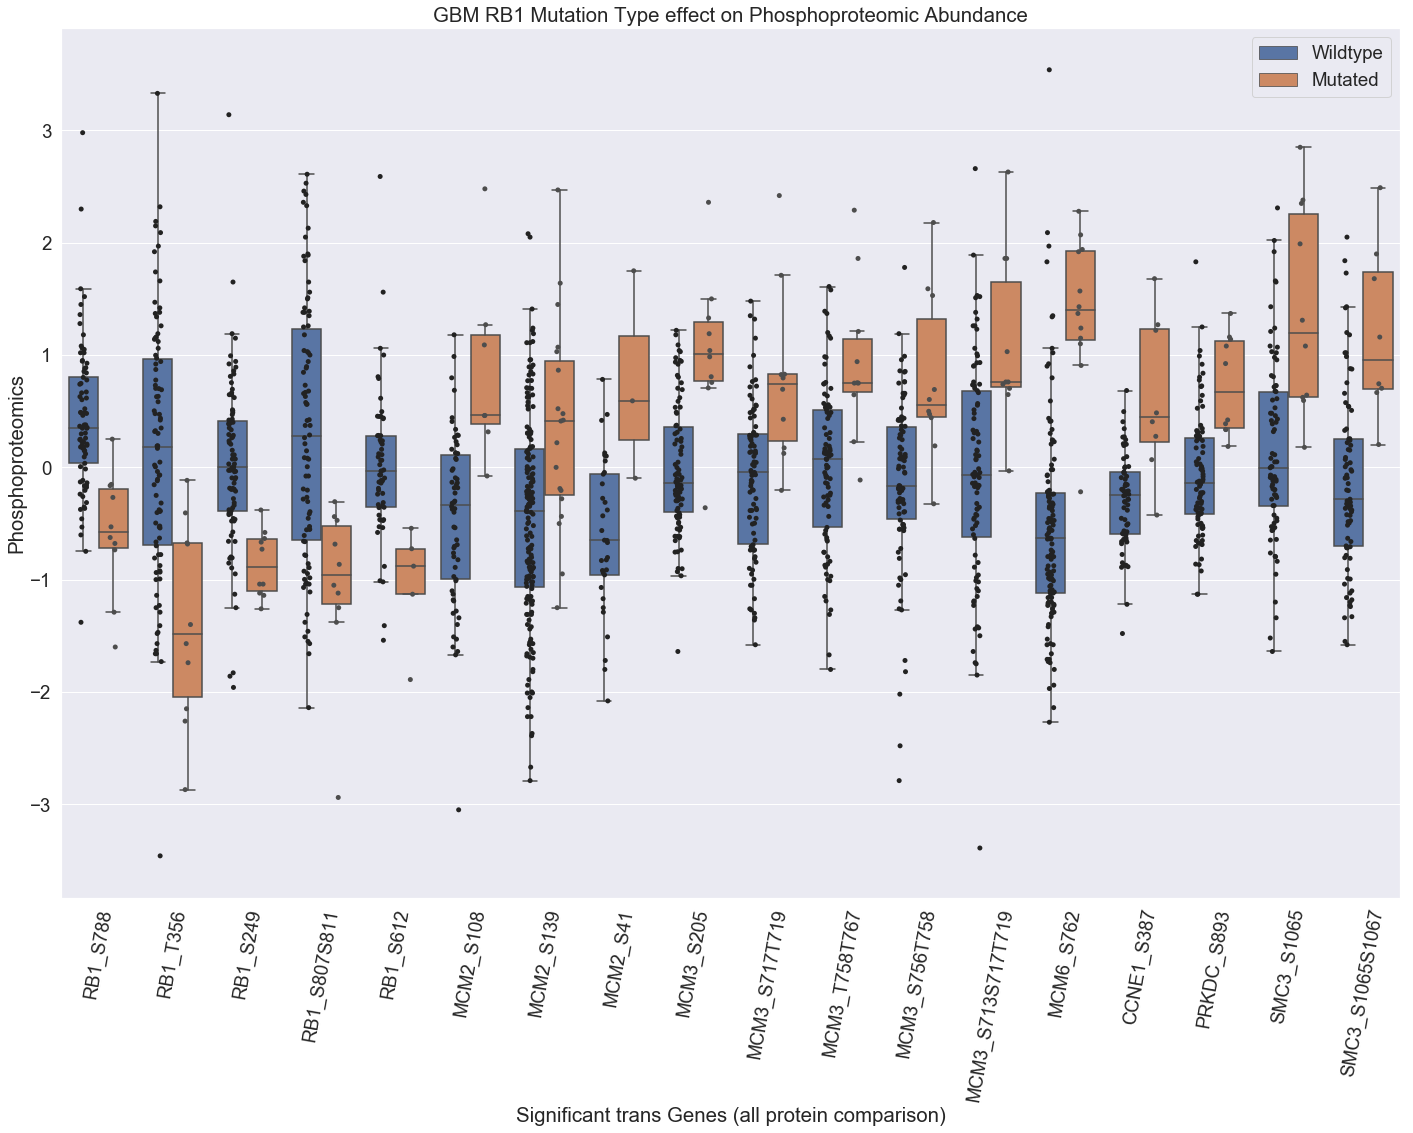

In [87]:
# Visualize
#plt.rcParams['figure.figsize']=(8,5) #size of plot
sns.set(font_scale = 1.7)

plt.rcParams['figure.figsize']=(24,16) #size of plot
boxplot = sns.boxplot(x='specific_phospho', y="phosphoproteomics", hue = 'binary_mutations', 
                         hue_order = ['Wildtype', 'Mutated'], data = RB1_all, showfliers = False)    
boxplot.set_title("GBM RB1 Mutation Type effect on Phosphoproteomic Abundance")
boxplot = sns.stripplot(x='specific_phospho', y="phosphoproteomics", hue = 'binary_mutations', data = RB1_all, jitter = True, 
                           color = ".3", hue_order = ['Wildtype', 'Mutated'], dodge = True)
boxplot.set(xlabel = "Significant trans Genes (all protein comparison)", ylabel = 'Phosphoproteomics')

boxplot.set_xticklabels(boxplot.get_xticklabels(),rotation = 80)

# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2])

plt.show()
plt.clf()
plt.close()

In [69]:
# Create Dataframe 
'''
RB1_cis_mut = phospho_df_RB1.assign(Gene= "RB1")
MCM2_trans_mut = phospho_df_MCM2.assign(Gene = "MCM2")
MCM3_trans_mut = phospho_df_MCM3.assign(Gene = "MCM3")
MCM6_trans_mut = phospho_df_MCM6.assign(Gene = "MCM6")
CCNE1_trans_mut = phospho_df_CCNE1.assign(Gene = "CCNE1")
PRKDC_trans_mut = phospho_df_PRKDC.assign(Gene = "PRKDC")
SMC3_trans_mut = phospho_df_SMC3.assign(Gene = "SMC3")'''

RB1_all_trunc = pd.concat([phospho_df_RB1_t, phospho_df_MCM2_t, phospho_df_MCM3_t, phospho_df_MCM6_t, phospho_df_CCNE1_t, phospho_df_PRKDC_t, phospho_df_SMC3_t])
#RB1_alldf = pd.melt(RB1_all, id_vars = ["Gene", 'binary_mutations'], value_name = "omics")

RB1_all_trunc

,binary_mutations,specific_phospho,phosphoproteomics
0,Truncation,RB1_S788,-0.678
1,Truncation,RB1_S788,-0.152
2,Truncation,RB1_S788,-0.625
3,Truncation,RB1_S788,-0.163
4,Truncation,RB1_S788,-1.600
...,...,...,...
195,Wildtype,SMC3_S1065S1067,0.251
196,Wildtype,SMC3_S1065S1067,-1.100
197,Wildtype,SMC3_S1065S1067,-1.160
198,Wildtype,SMC3_S1065S1067,-0.422


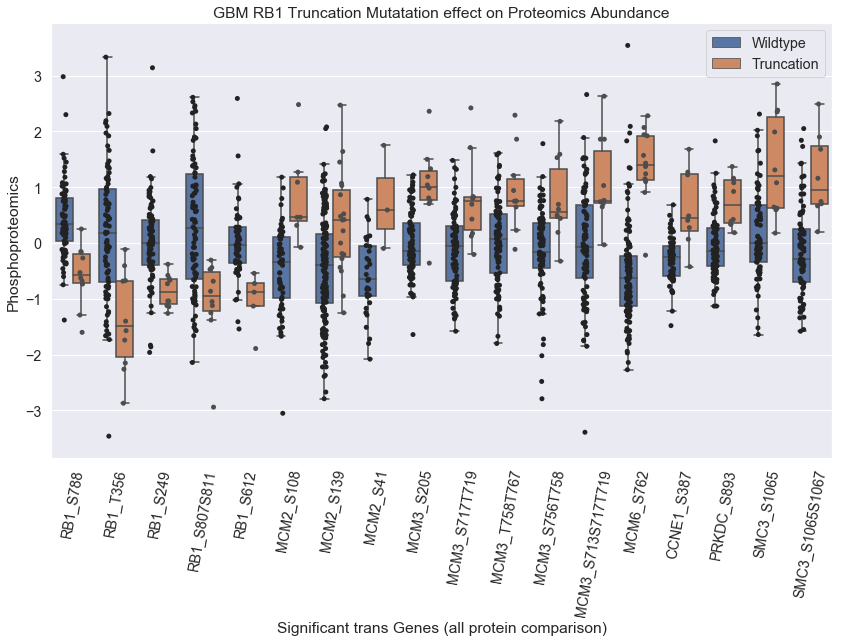

In [89]:
# Visualize

#plt.rcParams['figure.figsize']=(20,10) #size of plot
sns.set(font_scale = 1.3)

plt.rcParams['figure.figsize']=(14,8) #size of plot
boxplot = sns.boxplot(x='specific_phospho', y="phosphoproteomics", hue = 'binary_mutations', 
                         hue_order = ['Wildtype', 'Truncation'], data = RB1_all_trunc, showfliers = False)    
boxplot.set_title("GBM RB1 Truncation Mutatation effect on Proteomics Abundance")
boxplot = sns.stripplot(x='specific_phospho', y="phosphoproteomics", hue = 'binary_mutations', data = RB1_all_trunc, jitter = True, 
                           color = ".3", hue_order = ['Wildtype', 'Truncation'], dodge = True)
boxplot.set(xlabel = "Significant trans Genes (all protein comparison)", ylabel = 'Phosphoproteomics')

boxplot.set_xticklabels(boxplot.get_xticklabels(),rotation = 80)

# format legend
handles, labels = boxplot.get_legend_handles_labels()
plt.legend(handles[0:2], labels[0:2])

plt.show()
plt.clf()
plt.close()

# Extra checks 

looking for E2F1 in transcriptomics and proteomics 

In [ ]:
#num_freq_mut_genes = len(freq_mut)
num_freq_mut_genes = 20
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest - drop 
transrcpt_mutations = brain.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'transcriptomics', omics_genes = "E2F1")
reduced_transcript_mutations = brain.reduce_multiindex(transrcpt_mutations, levels_to_drop=1) #single col labels

# Step 2 & 3 - Get binary column and format
transcript_mut_wt = format_mutated_wt_comparison(reduced_transcript_mutations)
transcript_mut_wt

In [ ]:
# Step 4 - T-test
trans_col_list = ['E2F1_transcriptomics']
trans_col = 'E2F1_transcriptomics'

print("Doing t-test comparison for mutation status")
transcript_results = wrap_ttest_return_all(transcript_mut_wt, 'binary_mutations', trans_col_list, num_freq_mut_genes)
transcript_results = transcript_results.rename(index = {0: "Mutated/Wildtype"})
transcript_results

In [ ]:

# Step 1 - Create dataframe in order to do comparisons with wrap_ttest  
prot_and_mutations = brain.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'proteomics', omics_genes = "E2F1") # single col level


# Step 2 & 3 - Get binary column and format
prot_mut_wt = format_mutated_wt_comparison(prot_and_mutations)
prot_mut_wt.loc[prot_mut_wt ["binary_mutations"] == "Mutated"]

In [ ]:
#num_freq_mut_genes = len(freq_mut) 
num_freq_mut_genes = 20
prot_col_list = ["E2F1"+'_proteomics']
prot_col = "E2F1"+"_proteomics"

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutated and wildtype")
prot_results = wrap_ttest_return_all(prot_mut_wt, 'binary_mutations', prot_col_list, num_freq_mut_genes)
prot_results = prot_results.rename(index = {0: "Mutated/Wildtype"})
prot_results

In [ ]:
df = brain.get_proteomics()
E2_cols = [col for col in df.columns if "E2" in col]
print (E2_cols)

In [ ]:
df["E2F3"]

looking for CCNE1

In [ ]:
#num_freq_mut_genes = len(freq_mut)
num_freq_mut_genes = 20
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest - drop 
transrcpt_mutations = brain.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'transcriptomics', omics_genes = "CCNE1")
reduced_transcript_mutations = brain.reduce_multiindex(transrcpt_mutations, levels_to_drop=1) #single col labels

# Step 2 & 3 - Get binary column and format
transcript_mut_wt = format_mutated_wt_comparison(reduced_transcript_mutations)
transcript_mut_wt

In [ ]:
# Step 4 - T-test
trans_col_list = ['CCNE1_transcriptomics']
trans_col = 'CCNE1_transcriptomics'

print("Doing t-test comparison for mutation status")
transcript_results = wrap_ttest_return_all(transcript_mut_wt, 'binary_mutations', trans_col_list, num_freq_mut_genes)
transcript_results = transcript_results.rename(index = {0: "Mutated/Wildtype"})
transcript_results

In [ ]:

# Step 1 - Create dataframe in order to do comparisons with wrap_ttest  
prot_and_mutations = brain.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'proteomics', omics_genes = "CCNE1") # single col level


# Step 2 & 3 - Get binary column and format
prot_mut_wt = format_mutated_wt_comparison(prot_and_mutations)
prot_mut_wt.loc[prot_mut_wt ["binary_mutations"] == "Mutated"]

In [ ]:
#num_freq_mut_genes = len(freq_mut) 
num_freq_mut_genes = 20
prot_col_list = ["CCNE1"+'_proteomics']
prot_col = "CCNE1"+"_proteomics"

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutated and wildtype")
prot_results = wrap_ttest_return_all(prot_mut_wt, 'binary_mutations', prot_col_list, num_freq_mut_genes)
prot_results = prot_results.rename(index = {0: "Mutated/Wildtype"})
prot_results

In [ ]:
df = brain.get_proteomics()
CCN_cols = [col for col in df.columns if "CCN" in col]
print (CCN_cols)


In [ ]:
df.columns.get_loc("CCND1")
df.iloc[0:4,1465:1480]

could not find E2F1 or CCNE1 in proteomics, but were significant in transcriptomics. 